In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
import datetime


%matplotlib inline

In [2]:
import geopy.distance
######codes for loading historical original airquality and weather data
def get_df_in_range(df,start,end,attr_name):
    return df.loc[(df[attr_name] >= start) & (df[attr_name] < end)]

def load_old_all(start_17='2017-02-14 00:00:00',end_17='2017-07-01 00:00:00',start_18='2018-02-01 00:00:00',end_18='2018-04-01 00:00:00'):
    '''
        Load all data needed in 2017.02.14-2017.06.30 & 2018.02.01 - 2018.03.31
    '''
    aq_year_df = pd.read_csv('/mnt/disks/bdt/5002/data/airQuality_201701-201801.csv')
    grid_year_df = pd.read_csv('/mnt/disks/bdt/5002/data/gridWeather_201701-201803.csv')
    ob_year_df = pd.read_csv('/mnt/disks/bdt/5002/data/observedWeather_201701-201801.csv')

    aq_year_needed = get_df_in_range(aq_year_df,start_17, end_17,'utc_time')
    grid_year_needed = get_df_in_range(grid_year_df,start_17, end_17,'utc_time')
    ob_year_needed = get_df_in_range(ob_year_df,start_17, end_17,'utc_time')

    aq_year_df1 = pd.read_csv('/mnt/disks/bdt/5002/data/airQuality_201802-201803.csv')
    ob_year_df1 = pd.read_csv('/mnt/disks/bdt/5002/data/observedWeather_201802-201803.csv')
    grid_year_df1 = get_df_in_range(grid_year_df,start_18, end_18,'utc_time')
    aq_year_df1 = get_df_in_range(aq_year_df1,start_18, end_18,'utc_time')
    ob_year_df1 = get_df_in_range(ob_year_df1,start_18,end_18,'utc_time')

    aq_old = pd.concat([aq_year_needed,aq_year_df1],axis=0)
    ob_old = pd.concat([ob_year_needed,ob_year_df1],axis=0)
    grid_old = pd.concat([grid_year_needed,grid_year_df1],axis=0)

    ob_old = ob_old.drop(['latitude','longitude'],axis=1)
    grid_old['station_id'] = grid_old['stationName']
    grid_old = grid_old.drop(['stationName'],axis=1)
    
    #load geo df
    aq_geo = pd.read_csv('/mnt/disks/bdt/5002/data/aq_geo.csv')
    ob_geo = pd.read_csv('/mnt/disks/bdt/5002/data/observeWeather_geo.csv')
    
    aq_old = aq_old.merge(aq_geo,how='left',left_on=['stationId'],right_on=['station_id'])
    aq_old  = aq_old.drop(['stationId'],axis=1)
    
    ob_old = ob_old.merge(ob_geo[['latitude','longitude','station_id']],how='left',on='station_id')

    return aq_old,ob_old,grid_old
	
######code for filling the weather info
def get_aq_w_dist():
    aq_geo = pd.read_csv('/mnt/disks/bdt/5002/data/aq_geo.csv')[['station_id','latitude','longitude']].values
    obs_geo = pd.read_csv('/mnt/disks/bdt/5002/data/observeWeather_geo.csv')[['station_id','latitude','longitude']].values
    grid_geo = pd.read_csv('/mnt/disks/bdt/5002/data/Beijing_grid_weather_station.csv',names=['station_id','latitude','longitude'])[['station_id','latitude','longitude']].values
    
    aq_start = []
    w_end = []
    dist_list = []
    for i in range(aq_geo.shape[0]):
        for j in range(obs_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(obs_geo[j][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(obs_geo[j][1],obs_geo[j][2])).km)

        for k in range(grid_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(grid_geo[k][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(grid_geo[k][1],grid_geo[k][2])).km)
    aq_w_dist_df = pd.DataFrame({'aq_start':aq_start,'w_end':w_end,'dist':dist_list})
    aq_w_dist_df = aq_w_dist_df.sort_values(by=['aq_start','dist'])
    
    #get top 3 nearest station for each aq_station
    top3_dict = {}
    aq_w_grouped = aq_w_dist_df.groupby('aq_start')
    for key,group in aq_w_grouped:
        top3_dict[key] = group['w_end'].values[:3]
    aq_group = aq_w_dist_df.groupby('aq_start',as_index=False)
    return aq_group

def clean_weather(df):
    df = df.loc[df.humidity < 100]
    df = df.loc[df.pressure < 3000]
    df = df.loc[df.temperature < 60]
    return df
	
def add_nearest_weather(aq_df,weather_all,aq_w_dist_group,level,time_column,weather_attrs = [ 'humidity', 'pressure', 'temperature']):
    '''
        This function find the nearesr weather station for the air quality data
    '''
    if level == 0:
        print("level 0 before fill: ",aq_df.shape[0]) 	
        new_df1 = pd.merge(aq_df, aq_w_dist_group.nth(0),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_all = pd.merge(new_df1, weather_all[weather_attrs+['station_id',time_column]],  how='left', left_on=['w_end',time_column], right_on = ['station_id',time_column])
        print("level 1 after fill: ",aq_all.shape[0])
        return aq_all
    else:
        #print("level"+str(level)+" before fill: ",aq_df.shape[0])
        aq_na_df = aq_df[aq_df[weather_attrs].isnull().any(axis=1)]
        aq_not_na_df = aq_df[~aq_df[weather_attrs].isnull().any(axis=1)]
        print("not na vs na:",aq_not_na_df.shape[0],aq_na_df.shape[0])    
        to_drop = ['aq_start','dist', 'w_end', 'id_y', 'station_id_y']+weather_attrs
        real_drop = [x for x in to_drop if x in aq_na_df.columns]    
        aq_na_df = aq_na_df.drop(real_drop,axis=1)
        old_columns = aq_na_df.columns
        new_columns = [x[:-2] if x.endswith('_x') else x for x in old_columns]

        aq_na_df.columns = new_columns 
        
        new_df2 = pd.merge(aq_na_df,aq_w_dist_group.nth(level),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_na_df_new = pd.merge(new_df2, weather_all[weather_attrs+['station_id',time_column]],  how='left', left_on=['w_end',time_column], right_on = ['station_id',time_column])
        aq_new_all = pd.concat([aq_not_na_df,aq_na_df_new],axis=0)
        #print("level"+str(level)+" after fill: ",aq_new_all.shape[0])
        #print(aq_not_na_df.columns)
        #print(aq_na_df_new.columns)
        return aq_new_all
		
def fill_weather_gap(aq_df,weather_df,levels,time_column,weather_attrs=['humidity','pressure','temperature']):
    aq_group = get_aq_w_dist()
    aq_all = add_nearest_weather(aq_df,weather_df,aq_group,0,time_column,weather_attrs)
    for i in range(1,levels):
        print("Level "+str(i)+" #null before",aq_all[weather_attrs].isnull().any(axis=1).sum())
        aq_all = add_nearest_weather(aq_all,weather_df,aq_group,i,time_column,weather_attrs)
        print("After: ",aq_all[weather_attrs].isnull().any(axis=1).sum())
    aq_all['station_id'] = aq_all['station_id_x']
    aq_all = aq_all.drop(['station_id_x','station_id_y','aq_start'],axis=1)
    return aq_all

In [3]:
#load the historial data in 2017 and 2018
#here I use data from 2017-02-14-2017-07-01 and 2018-02-01 2018-04-01
weather_used_old = ['pressure','temperature','humidity','wind_direction','wind_speed/kph']
aq_old,ob_old,grid_old = load_old_all(start_17='2017-03-01 00:00:00',end_17='2017-05-03 12:00:00',start_18='2018-03-01 00:00:00',end_18='2018-04-01 00:00:00')

#prepare weather data
weather_old_all = pd.concat([ob_old,grid_old]).reset_index()
weather_old_all = clean_weather(weather_old_all)
weather_old_all = weather_old_all.drop(['latitude','longitude'],axis=1)
weather_old_all = weather_old_all.drop_duplicates(subset=['utc_time','station_id'])

#add time columns to airQuality data
#levels is the number of nearest weather station to search
#time_column is the name of the time column
print("before fill: ",aq_old.shape[0])
aq_old_all = fill_weather_gap(aq_df=aq_old,weather_df=weather_old_all,levels = 1,time_column = 'utc_time',weather_attrs=weather_used_old)
print("after fill: ",aq_old_all.shape[0])

aq_old_all['timestamp'] = pd.to_datetime(aq_old_all['utc_time'])
aq_old_all['year'] = aq_old_all['timestamp'].dt.year
aq_old_all['month'] = aq_old_all['timestamp'].dt.month
aq_old_all['day'] = aq_old_all['timestamp'].dt.day
aq_old_all['hour'] = aq_old_all['timestamp'].dt.hour


before fill:  74515
level 0 before fill:  74515
level 1 after fill:  74515
after fill:  74515


In [4]:
def generate(dataframe,start='2018-05-01 00:00:00',end='2018-05-02 22:00:00'):
    stations = dataframe['station_id'].unique()
    columns = list(dataframe.columns)
    whole=None
    for i in list(stations):
        #print(i)
        section = pd.DataFrame({'time':pd.date_range(start=start, end=end, freq='1h')})
        #print(section)
        section['time']=section['time'].apply(lambda x: str(x))
        for k in columns:
            if k == 'station_id':
                section[k] = i
            elif k == 'time':
                continue
            else:
                section[k]=0               
        try:
            whole = whole.append(section)
        except:
            whole = section
        #print(whole)
    return whole.sort_values(by=['time'])

In [5]:
weather_used = ['pressure','temperature','humidity','wind_direction','wind_speed']
aq_df4 = pd.read_csv('/mnt/disks/bdt/5002/data/aiqQuality_201804.csv')
grid_df4 = pd.read_csv('/mnt/disks/bdt/5002/data/gridWeather_201804.csv')
ob_df4 = pd.read_csv('/mnt/disks/bdt/5002/data/observedWeather_201804.csv')

test_grid = pd.read_csv('/mnt/disks/bdt/5002/data/gridWeather_20180501-20180502.csv')
test_weather = pd.read_csv('/mnt/disks/bdt/5002/data/observedWeather_20180501-20180502.csv')
airq_5= generate(aq_df4,'2018-05-01 00:00:00','2018-05-02 23:00:00')
print("aq5 before:",airq_5.shape)
gt = pd.read_csv('/mnt/disks/bdt/5002/data/external_0501-0502.csv')
gt = gt.sort_values(by='time').reset_index(drop=True)
airq_5 = airq_5[['time','station_id']].merge(gt,how='left',on=['station_id','time'])
print("aq5 after:",airq_5.shape)
aq_df4 = aq_df4.append(airq_5)



#prepare weather data
weather_all = pd.concat([ob_df4,grid_df4,test_grid,test_weather]).reset_index()
weather_all = clean_weather(weather_all)

aq5 before: (1680, 9)
aq5 after: (1680, 9)


In [6]:
#add time columns to airQuality data
#levels is the number of nearest weather station to search
#time_column is the name of the time column
aq_all = fill_weather_gap(aq_df=aq_df4,weather_df=weather_all,levels = 1,time_column = 'time',weather_attrs=weather_used)


aq_all['timestamp'] = pd.to_datetime(aq_all['time'])
aq_all['year'] = aq_all['timestamp'].dt.year
aq_all['month'] = aq_all['timestamp'].dt.month
aq_all['day'] = aq_all['timestamp'].dt.day
aq_all['hour'] = aq_all['timestamp'].dt.hour

level 0 before fill:  24990
level 1 after fill:  24990


In [7]:
#adjust different columns names
old_columns = aq_all.columns
new_columns = [x[:-14] if x.endswith('_Concentration') else x for x in old_columns]
aq_all.columns = new_columns

#add geo info of the air quality stations for nearest weather station searching
aq_geo = pd.read_csv('/mnt/disks/bdt/5002/data/aq_geo.csv')
aq_all = aq_all.merge(aq_geo,how='left',on='station_id')
aq_all = aq_all.drop(['id'],axis=1)

In [8]:
#update the name of historical data
old_columns = list(aq_old_all.columns)
old_columns[old_columns.index('PM2.5')] = 'PM25'
old_columns[old_columns.index('wind_speed/kph')] = 'wind_speed'
old_columns[old_columns.index('utc_time')] = 'time'
aq_old_all.columns = old_columns

In [9]:
#seperate data into 2017 and 2018
aq_2017 = aq_old_all.loc[aq_old_all.year == 2017]
aq_2018_old = aq_old_all.loc[aq_old_all.year == 2018]
aq_2018 = pd.concat([aq_2018_old,aq_all],axis=0)

In [10]:
weather_old_all['time'] = weather_old_all['utc_time']
weather_all_20172018 = pd.concat([weather_old_all[['station_id','time','weather']],weather_all[['station_id','time','weather']]],axis=0)
old_columns = list(weather_all_20172018.columns)
old_columns[old_columns.index('station_id')] = 'w_end'
weather_all_20172018.columns = old_columns

In [11]:
weather_old_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443023 entries, 0 to 1443626
Data columns (total 11 columns):
index             1443023 non-null int64
humidity          1443023 non-null float64
pressure          1443023 non-null float64
station_id        1443023 non-null object
temperature       1443023 non-null float64
utc_time          1443023 non-null object
weather           40769 non-null object
wind_direction    1443023 non-null float64
wind_speed        40769 non-null float64
wind_speed/kph    1402254 non-null float64
time              1443023 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 132.1+ MB


In [12]:
aq_2018 = aq_2018.merge(weather_all_20172018,how='left',on=['w_end','time'])
aq_2017 = aq_2017.merge(weather_all_20172018,how='left',on=['w_end','time'])

In [13]:
#prepare bad weather dict
weather_keys = list(set(aq_2018.weather.unique())|set(aq_2017.weather.unique()))
bad_weathers = ['Sleet','HAZE','Hail','Haze']
w_dict = {}
for w in weather_keys:
    if w in bad_weathers:
        w_dict[w] = 1
    else:
        w_dict[w] = 0

In [14]:
aq_2018 = aq_2018.set_index(pd.DatetimeIndex(aq_2018['timestamp']))
aq_2017 = aq_2017.set_index(pd.DatetimeIndex(aq_2017['timestamp']))
aq_2017 = aq_2017.drop_duplicates(subset = ['station_id','time'])
aq_2018 = aq_2018.drop_duplicates(subset=['station_id','time'])

In [15]:
aq_2017['date_h'] = aq_2017['timestamp'].apply(lambda x: (x.timetuple().tm_yday)*24 + x.hour +24)
aq_2018['date_h'] = aq_2018['timestamp'].apply(lambda x: (x.timetuple().tm_yday)*24+(x.hour) )

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-20 11:00:00' 'CLEAR_NIGHT' 27.0 3.5328170682068603]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 3.5328170682068603]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 3.5328170682068603]]
0
dongsi_aq


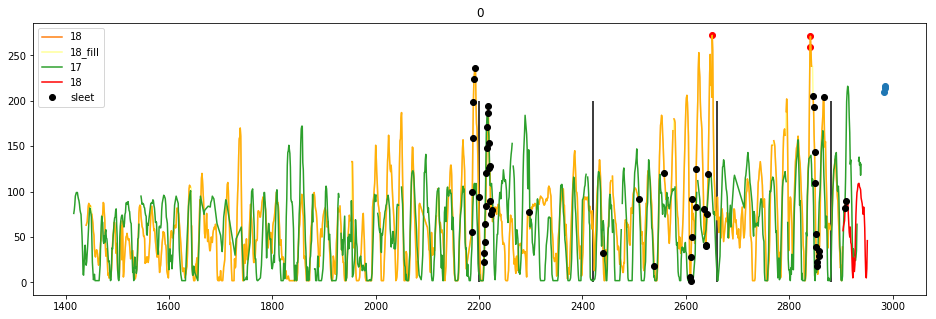

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-19 09:00:00' 'PARTLY_CLOUDY_DAY' 27.0 1.6657617351883103]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 1.6657617351883103]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 1.6657617351883103]]
0
tiantan_aq


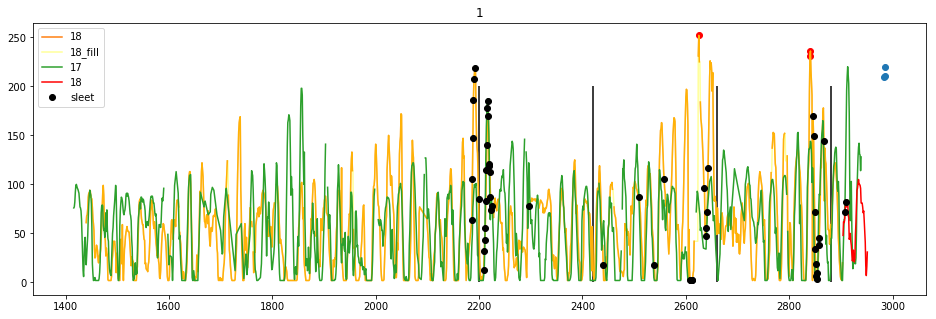

2017 ['2017-05-02 10:00:00' '2017-05-02 09:00:00' '2017-05-02 11:00:00']
2018 [['2018-04-20 09:00:00' 'CLEAR_DAY' 29.0 4.635415799187261]
 ['2018-04-19 10:00:00' 'CLOUDY' 26.0 4.635415799187261]
 ['2018-04-20 07:00:00' 'PARTLY_CLOUDY_DAY' 29.0 4.635415799187261]]
0
guanyuan_aq


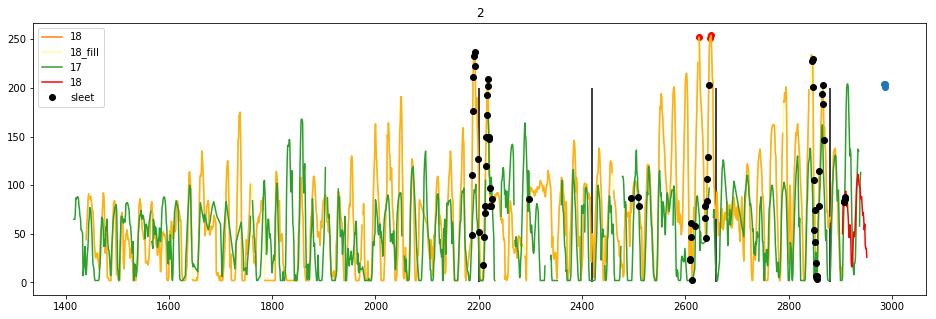

2017 ['2017-05-02 10:00:00' '2017-05-02 09:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-20 09:00:00' 'CLEAR_DAY' 29.0 4.777265692603123]
 ['2018-04-19 09:00:00' 'PARTLY_CLOUDY_DAY' 27.0 4.777265692603123]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 29.0 4.777265692603123]]
0
wanshouxigong_aq


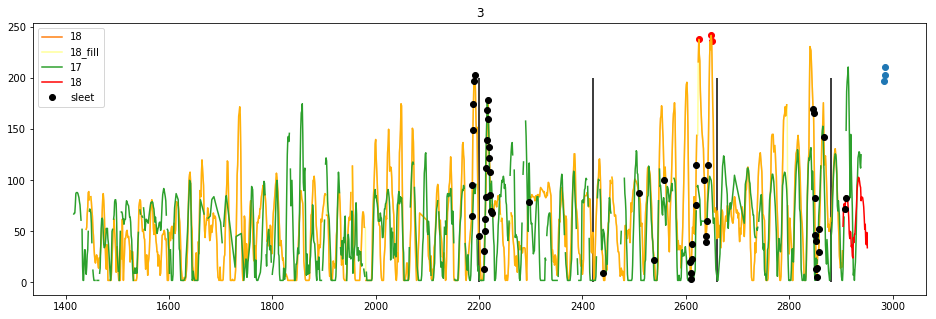

2017 ['2017-05-02 10:00:00' '2017-05-02 09:00:00' '2017-03-19 10:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 29.0 2.01497623391867]
 ['2018-04-19 09:00:00' 'PARTLY_CLOUDY_DAY' 27.0 2.01497623391867]
 ['2018-04-20 12:00:00' 'CLEAR_NIGHT' 25.0 2.01497623391867]]
0
aotizhongxin_aq


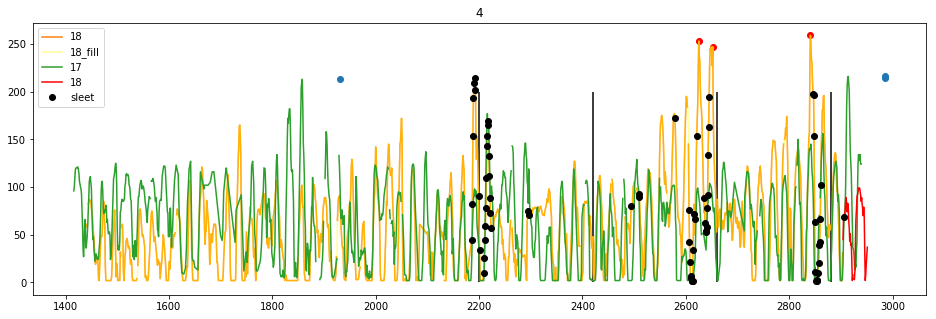

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-20 11:00:00' 'Hail' 26.3 3.8145653943195272]
 ['2018-04-20 10:00:00' 'Hail' 27.7 3.8145653943195272]
 ['2018-04-28 09:00:00' 'Hail' 28.3 3.8145653943195272]]
0
nongzhanguan_aq


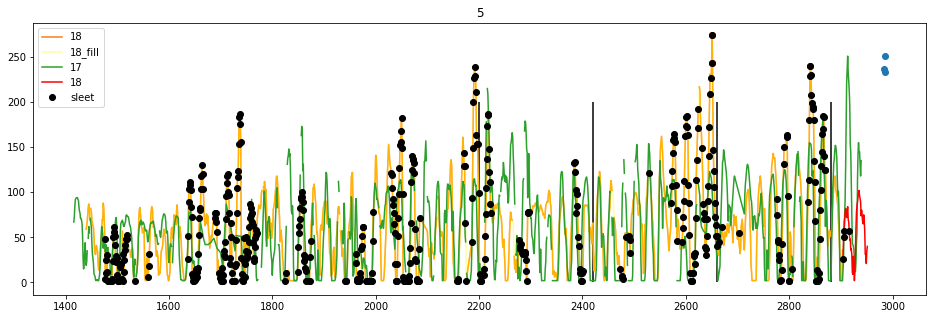

2017 ['2017-05-02 11:00:00' '2017-05-02 09:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-19 10:00:00' 'Sunny/clear' 25.7 0.3037429368585245]
 ['2018-04-19 09:00:00' 'Sunny/clear' 26.5 0.3037429368585245]
 ['2018-04-28 09:00:00' 'Sunny/clear' 28.9 0.3037429368585245]]
0
wanliu_aq


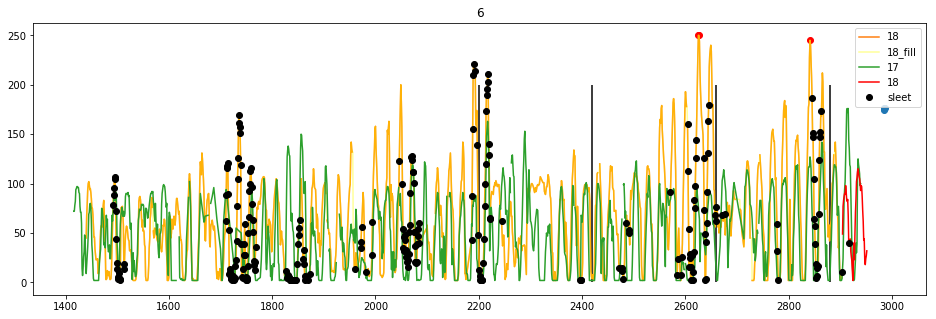

2017 ['2017-05-02 11:00:00' '2017-05-02 09:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-28 10:00:00' 'CLEAR_DAY' 28.0 2.4796591806879906]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 28.0 2.4796591806879906]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 29.0 2.4796591806879906]]
0
beibuxinqu_aq


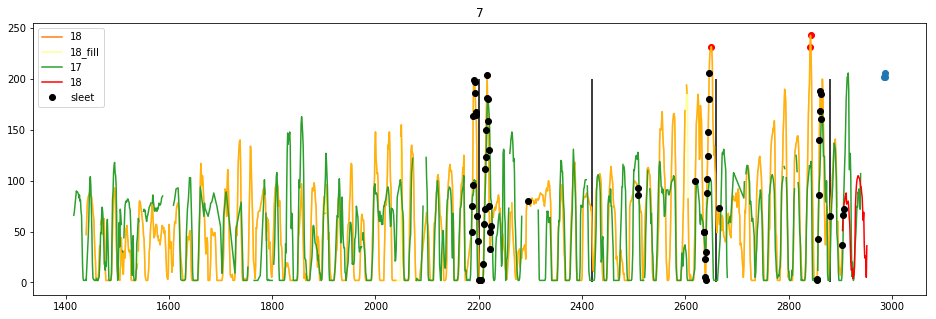

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-03-01 00:00:00' nan -0.27 0.6376658802053164]
 ['2018-03-01 01:00:00' nan 1.01 0.6376658802053164]
 ['2018-03-01 02:00:00' nan 2.3 0.6376658802053164]]
0
zhiwuyuan_aq


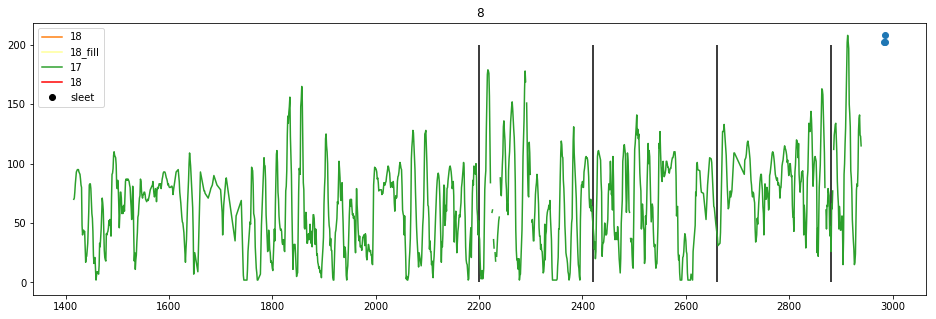

2017 ['2017-05-02 10:00:00' '2017-05-02 08:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-28 08:00:00' 'Sunny/clear' 29.0 2.9962851777823944]
 ['2018-04-28 10:00:00' 'Sunny/clear' 27.3 2.9962851777823944]
 ['2018-04-28 09:00:00' 'Sunny/clear' 28.9 2.9962851777823944]]
0
fengtaihuayuan_aq


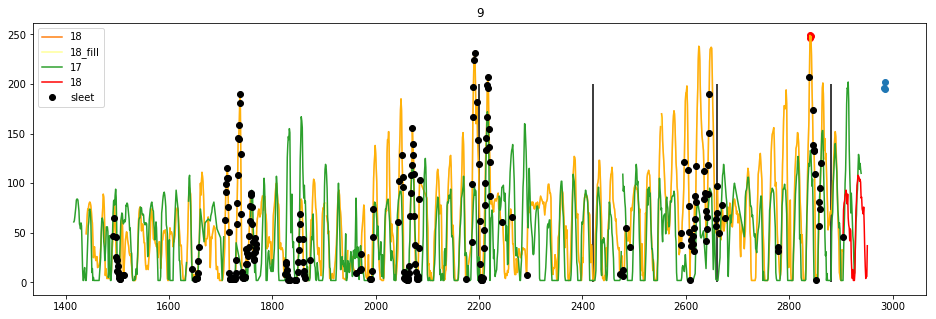

2017 ['2017-05-02 10:00:00' '2017-05-02 11:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 4.755580821092359]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 4.755580821092359]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 26.0 4.755580821092359]]
0
yungang_aq


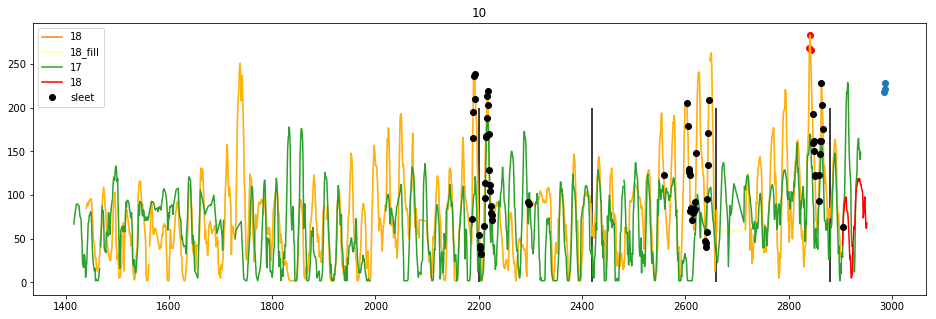

2017 ['2017-05-02 10:00:00' '2017-05-02 08:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 29.0 2.0707943483570737]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 27.0 2.0707943483570737]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 27.0 2.0707943483570737]]
0
gucheng_aq


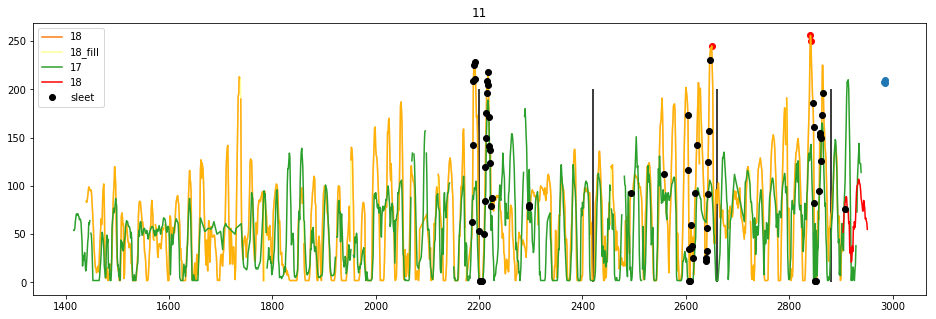

2017 ['2017-05-02 10:00:00' '2017-04-27 05:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 5.592239242666751]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 5.592239242666751]
 ['2018-04-19 09:00:00' 'PARTLY_CLOUDY_DAY' 28.0 5.592239242666751]]
1
fangshan_aq


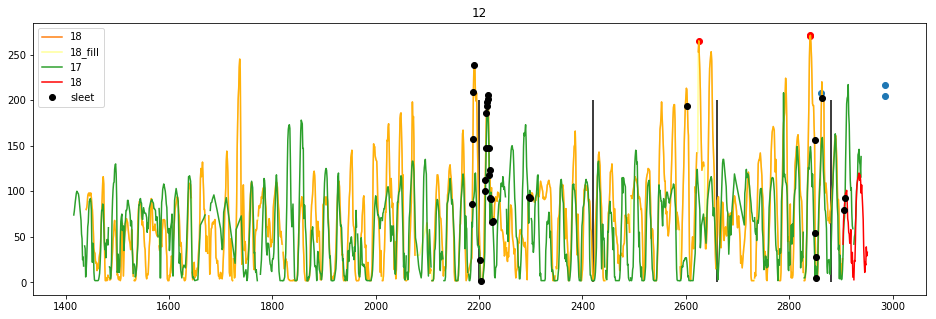

2017 ['2017-05-02 10:00:00' '2017-05-02 08:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-20 09:00:00' 'CLEAR_DAY' 29.0 2.0277467407226735]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 2.0277467407226735]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 2.0277467407226735]]
1
daxing_aq


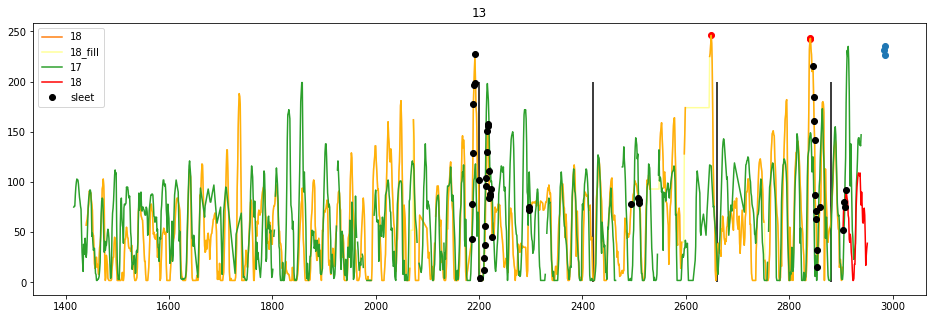

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-20 11:00:00' 'CLEAR_NIGHT' 27.0 0.7564796974825206]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 28.0 0.7564796974825206]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 0.7564796974825206]]
1
yizhuang_aq


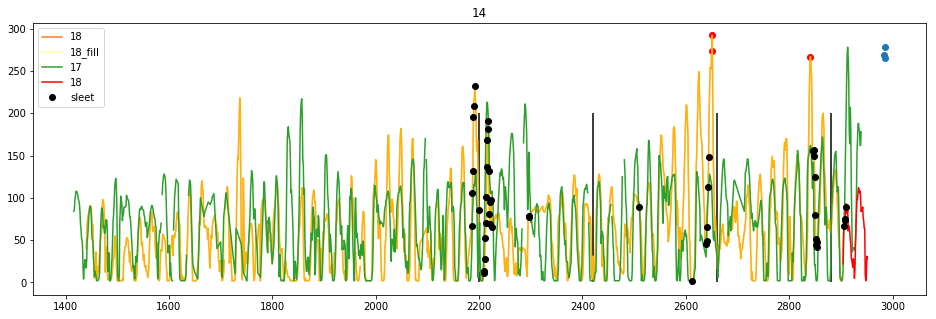

2017 ['2017-05-02 10:00:00' '2017-05-02 11:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-20 10:00:00' 'CLEAR_DAY' 27.0 3.5256752247868137]
 ['2018-04-20 09:00:00' 'CLEAR_DAY' 28.0 3.5256752247868137]
 ['2018-04-20 08:00:00' 'PARTLY_CLOUDY_DAY' 28.0 3.5256752247868137]]
1
tongzhou_aq


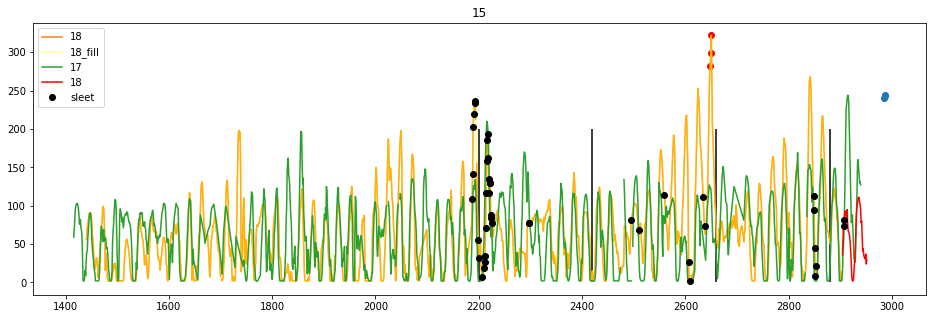

2017 ['2017-05-02 12:00:00' '2017-05-02 09:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-28 09:00:00' 'Hail' 28.1 3.3859518495315983]
 ['2018-04-28 10:00:00' 'Sunny/clear' 27.6 3.3859518495315983]
 ['2018-04-28 11:00:00' 'Sunny/clear' 26.2 3.3859518495315983]]
1
shunyi_aq


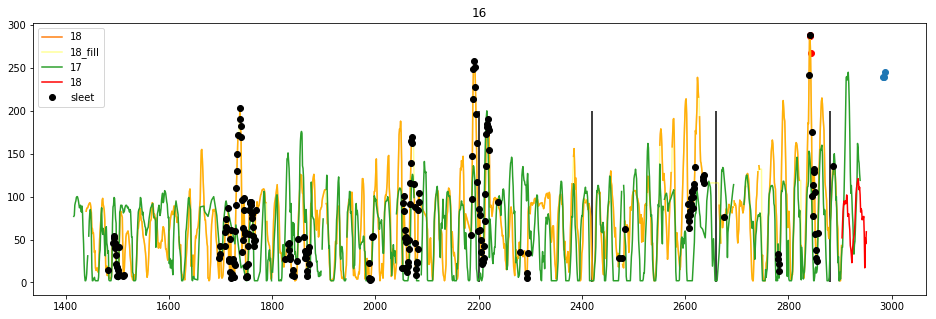

2017 ['2017-05-02 10:00:00' '2017-05-02 09:00:00' '2017-05-02 11:00:00']
2018 [['2018-04-20 07:00:00' 'Hail' 27.6 1.711654288777645]
 ['2018-04-01 08:00:00' 'Hail' 25.0 1.711654288777645]
 ['2018-04-28 11:00:00' 'Sunny/clear' 26.4 1.711654288777645]]
1
pingchang_aq


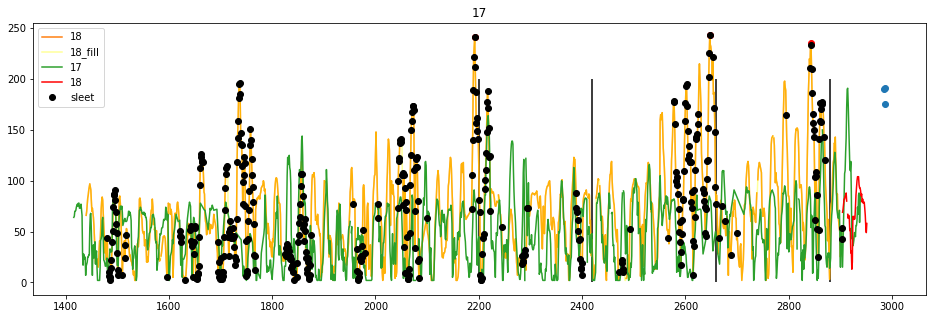

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 29.0 4.1401256112707125]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 28.0 4.1401256112707125]
 ['2018-04-29 09:00:00' 'PARTLY_CLOUDY_DAY' 27.0 4.1401256112707125]]
1
mentougou_aq


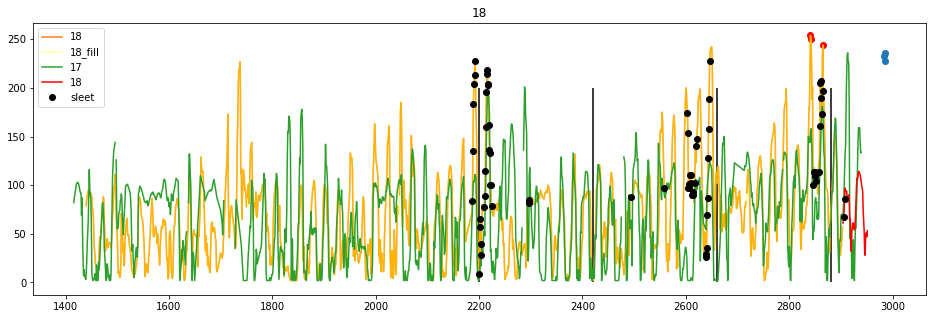

2017 ['2017-05-02 12:00:00' '2017-05-02 09:00:00' '2017-05-02 13:00:00']
2018 [['2018-04-28 10:00:00' 'Hail' 26.5 3.3039647928895244]
 ['2018-04-20 09:00:00' 'Hail' 28.2 3.3039647928895244]
 ['2018-04-20 10:00:00' 'Sunny/clear' 27.2 3.3039647928895244]]
1
pinggu_aq


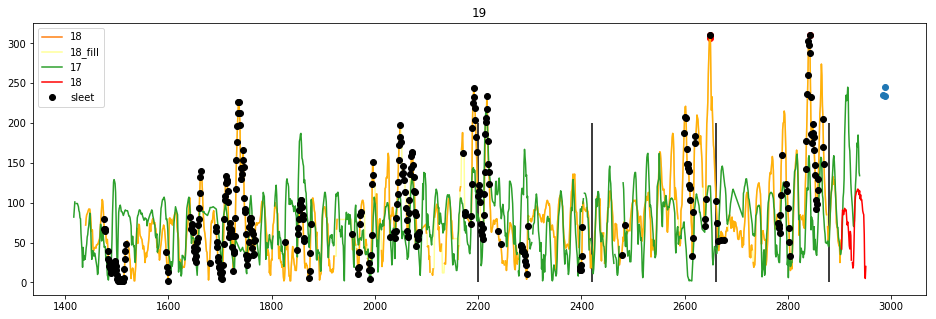

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 11:00:00']
2018 [['2018-04-20 11:00:00' 'Hail' 25.4 3.307777112207898]
 ['2018-04-20 10:00:00' 'Hail' 26.6 3.307777112207898]
 ['2018-04-20 09:00:00' 'Hail' 28.1 3.307777112207898]]
1
huairou_aq


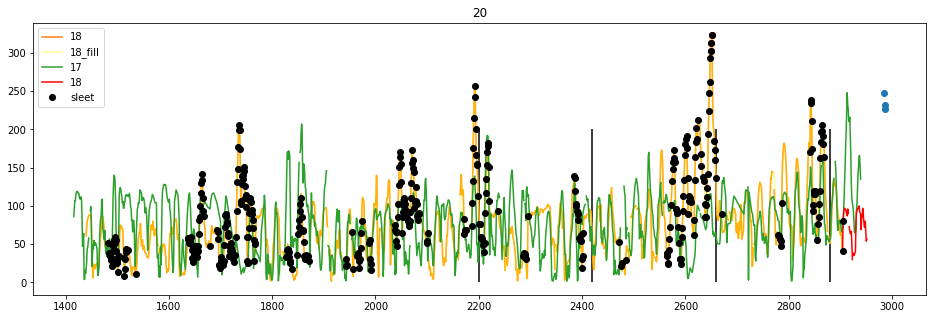

2017 ['2017-05-02 13:00:00' '2017-05-02 11:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-20 11:00:00' 'Hail' 26.1 2.855926618602037]
 ['2018-04-20 10:00:00' 'Hail' 27.2 2.855926618602037]
 ['2018-04-20 09:00:00' 'Hail' 27.7 2.855926618602037]]
1
miyun_aq


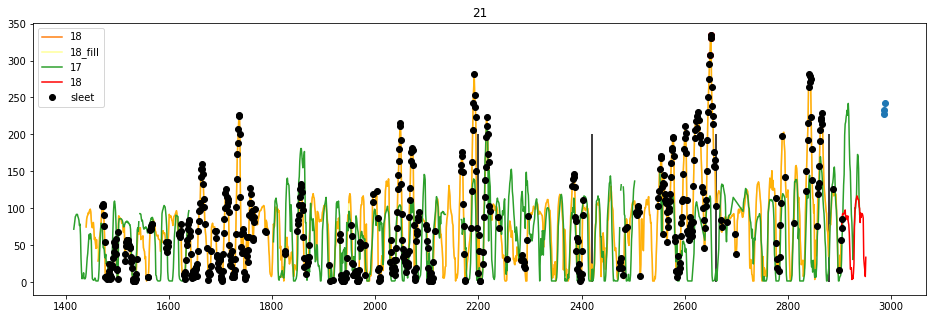

2017 ['2017-05-02 09:00:00' '2017-05-02 11:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-20 08:00:00' 'Hail' 24.4 0.4749035242445815]
 ['2018-04-20 07:00:00' 'Hail' 24.5 0.4749035242445815]
 ['2018-04-01 09:00:00' 'Hail' 22.1 0.4749035242445815]]
1
yanqin_aq


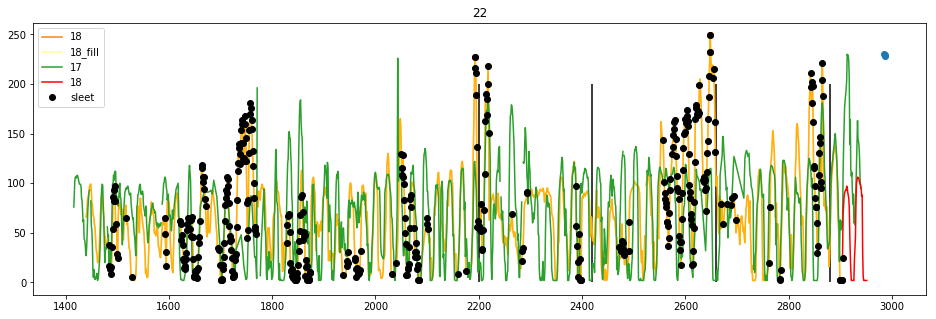

2017 ['2017-04-20 13:00:00' '2017-03-28 03:00:00' '2017-03-26 23:00:00']
2018 [['2018-04-20 13:00:00' 'PARTLY_CLOUDY_NIGHT' 25.0 1.9185277975484585]
 ['2018-04-01 08:00:00' 'HAZE' 25.0 1.9185277975484585]
 ['2018-04-01 09:00:00' 'HAZE' 26.0 1.9185277975484585]]
2
dingling_aq


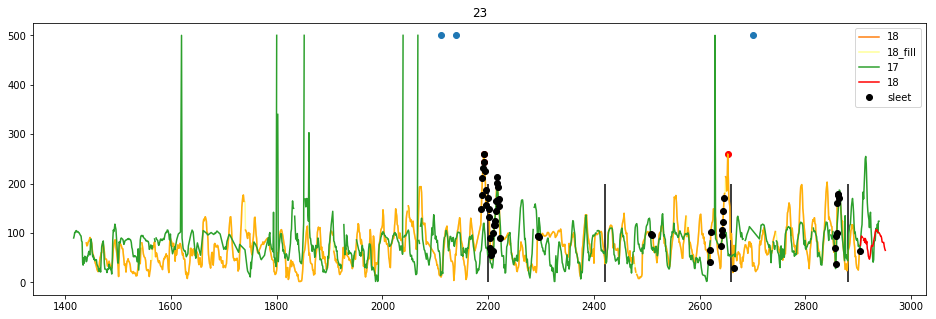

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 11:00:00']
2018 [['2018-04-20 08:00:00' 'WIND' 24.0 4.017832594225799]
 ['2018-04-20 07:00:00' 'PARTLY_CLOUDY_DAY' 25.0 4.017832594225799]
 ['2018-04-01 08:00:00' 'HAZE' 23.0 4.017832594225799]]
2
badaling_aq


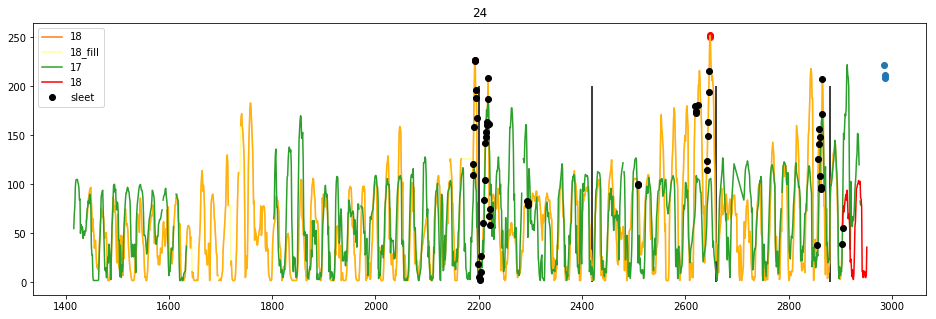

2017 ['2017-05-02 11:00:00' '2017-05-02 10:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-20 11:00:00' 'CLEAR_NIGHT' 27.0 0.9390410760207668]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 27.0 0.9390410760207668]
 ['2018-04-20 09:00:00' 'CLEAR_DAY' 28.0 0.9390410760207668]]
2
miyunshuiku_aq


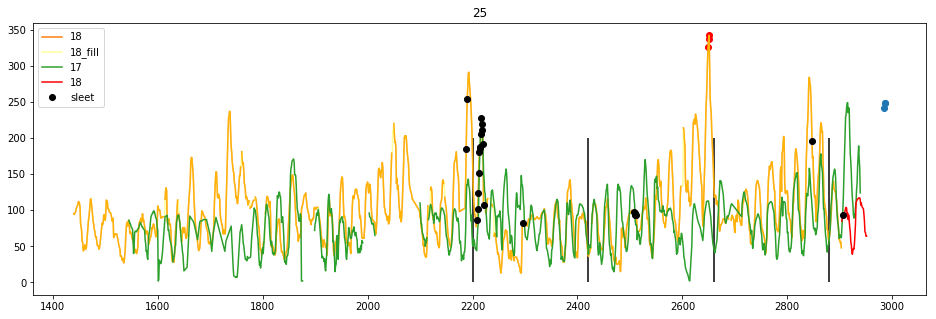

2017 ['2017-05-02 12:00:00' '2017-05-02 11:00:00' '2017-05-02 13:00:00']
2018 [['2018-04-20 09:00:00' 'CLEAR_DAY' 28.0 1.705383169474235]
 ['2018-04-20 08:00:00' 'PARTLY_CLOUDY_DAY' 29.0 1.705383169474235]
 ['2018-04-20 10:00:00' 'CLEAR_DAY' 28.0 1.705383169474235]]
2
donggaocun_aq


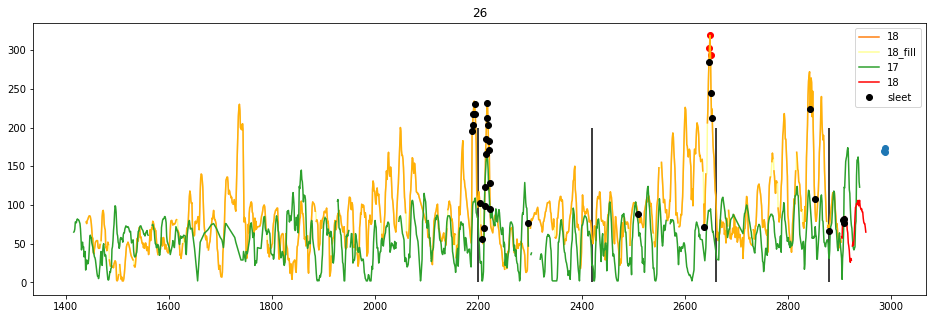

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 11:00:00']
2018 [['2018-04-20 09:00:00' 'CLEAR_DAY' 28.0 1.9750011659457618]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 29.0 1.9750011659457618]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 28.0 1.9750011659457618]]
2
yongledian_aq


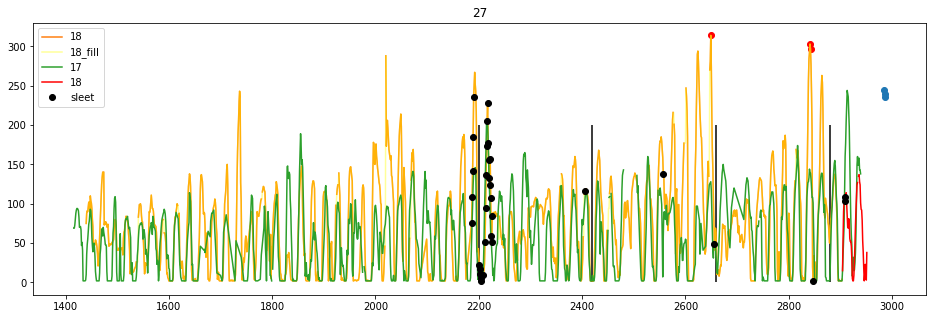

2017 ['2017-03-19 08:00:00' '2017-05-02 08:00:00' '2017-05-02 09:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 27.0 2.220504628712349]
 ['2018-04-01 06:00:00' 'HAZE' 24.0 2.220504628712349]
 ['2018-04-01 08:00:00' 'CLEAR_DAY' 28.0 2.220504628712349]]
2
yufa_aq


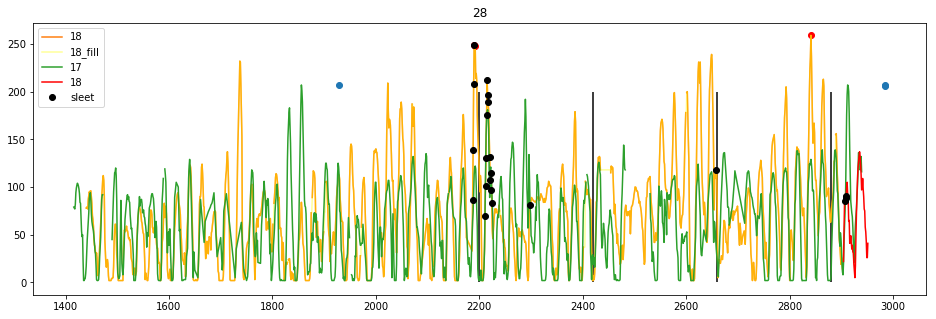

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-02 08:00:00' 'HAZE' 28.0 2.2205352834159786]
 ['2018-04-02 09:00:00' 'HAZE' 28.0 2.2205352834159786]
 ['2018-03-13 08:00:00' nan 20.04 2.2205352834159786]]
2
liulihe_aq


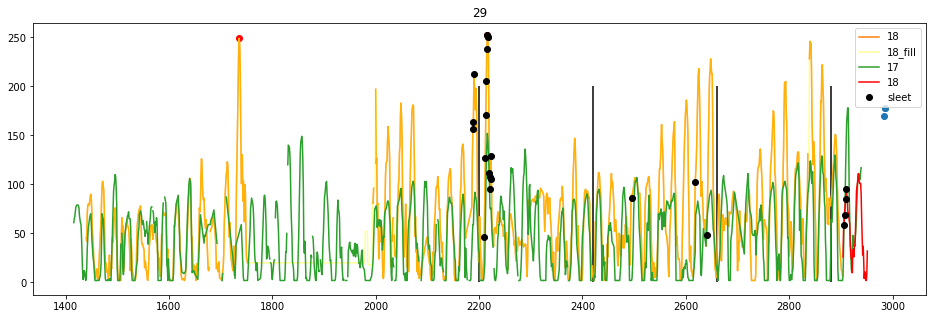

2017 ['2017-05-02 09:00:00' '2017-05-02 10:00:00' '2017-05-02 08:00:00']
2018 [['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 0.44177525743076973]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 27.0 0.44177525743076973]
 ['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 0.44177525743076973]]
3
qianmen_aq


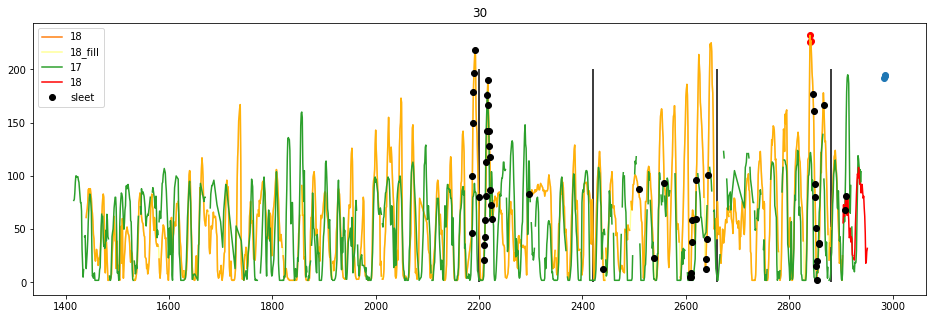

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 2.7137471279609118]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 2.7137471279609118]
 ['2018-04-28 10:00:00' 'CLEAR_DAY' 27.0 2.7137471279609118]]
3
yongdingmennei_aq


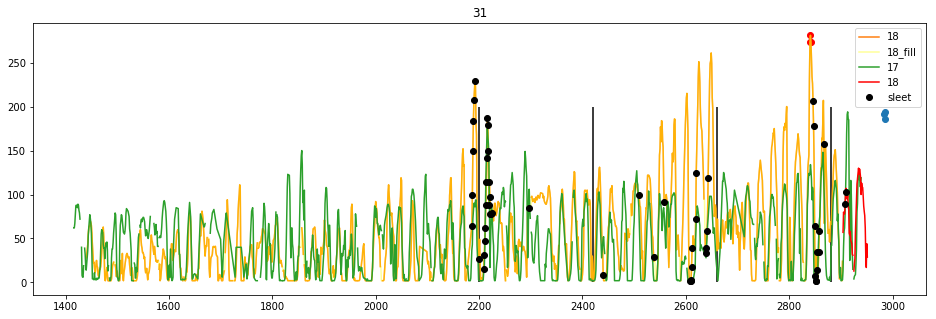

2017 ['2017-05-02 09:00:00' '2017-05-02 08:00:00' '2017-05-02 10:00:00']
2018 [['2018-04-19 09:00:00' 'Sunny/clear' 26.5 6.189518646240812]
 ['2018-04-19 10:00:00' 'Sunny/clear' 25.7 6.189518646240812]
 ['2018-04-28 09:00:00' 'Sunny/clear' 28.9 6.189518646240812]]
3
xizhimenbei_aq


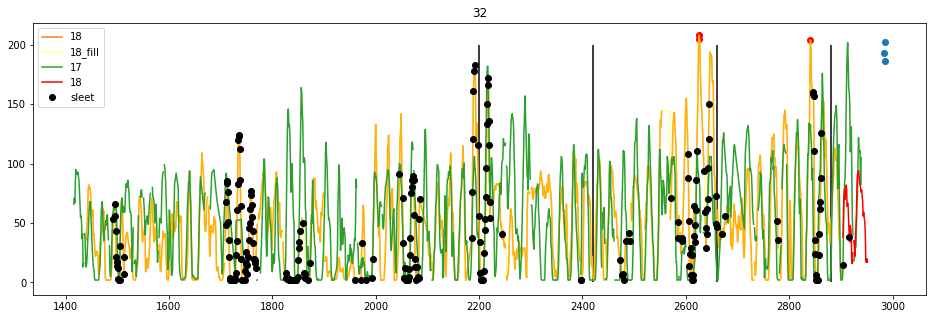

2017 ['2017-05-02 08:00:00' '2017-04-03 08:00:00' '2017-04-03 07:00:00']
2018 [['2018-04-28 09:00:00' 'CLEAR_DAY' 28.0 5.600091348749994]
 ['2018-04-28 08:00:00' 'CLEAR_DAY' 28.0 5.600091348749994]
 ['2018-04-20 07:00:00' 'PARTLY_CLOUDY_DAY' 29.0 5.600091348749994]]
3
nansanhuan_aq


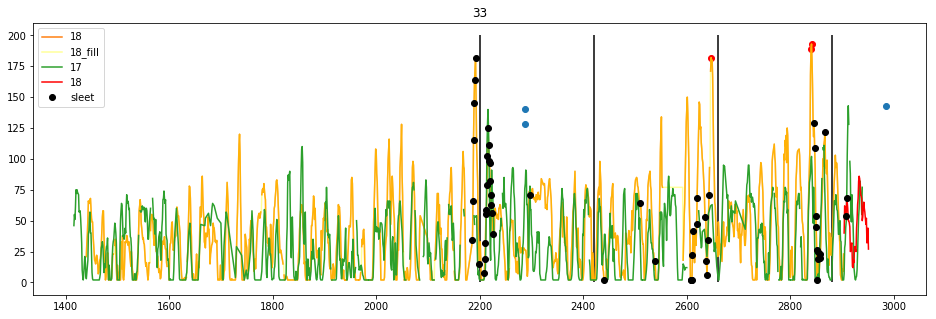

2017 ['2017-04-03 08:00:00' '2017-05-02 09:00:00' '2017-04-03 10:00:00']
2018 [['2018-04-28 09:00:00' 'Hail' 28.3 2.1376681396633805]
 ['2018-04-28 10:00:00' 'Hail' 27.3 2.1376681396633805]
 ['2018-04-20 09:00:00' 'Hail' 28.6 2.1376681396633805]]
3
dongsihuan_aq


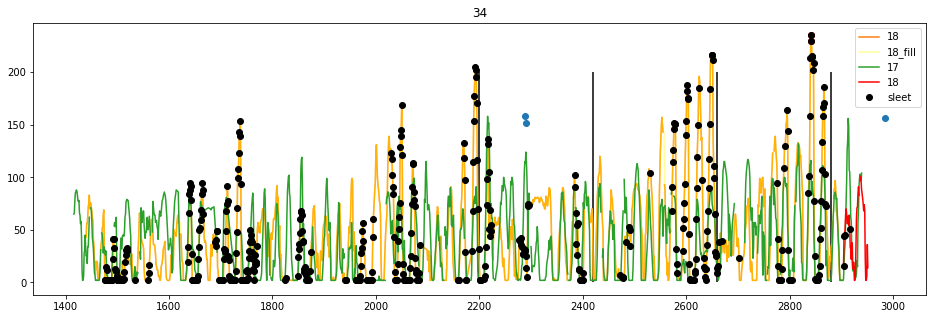

In [16]:
## check the distribution
grouped = aq_2018.groupby('station_id_int')
attr_test = 'O3'
for name,group in grouped:
    plt.figure(figsize=(16,5))
    
    #filter out extremly large value
    
    group = group.loc[(group.time < '2018-03-27 22:00:00') | (group.time > '2018-03-28 10:00:00')]
    
    #end of filter
    
    group = group.sort_values(by='date_h')
    group_train = group.loc[group.month != 5]
    group_test = group.loc[group.month == 5]
    group_2017 = aq_2017.loc[aq_2017.station_id_int == name]
    group_2017 = group_2017.sort_values(by='date_h')
    
    
    
    
    top3_2017 = group_2017.sort_values(by=attr_test,ascending=False)
    top3_2018 = group_train.sort_values(by=attr_test,ascending=False)
    print("2017",top3_2017['time'].values[:3])
    print("2018",top3_2018[['time','weather','temperature','dist']].values[:3])
    plt.plot(top3_2018.date_h.values[:3],top3_2018[attr_test].values[:3],'o',color='red')
    plt.plot(top3_2017.date_h.values[:3]+24,top3_2017[attr_test].values[:3],'o')
    #max_row_2017 = group_2017.ix[group_2017[attr_test].idxmax()]
    #print(max_row_2017.time)
    station_type_id = group_train.station_type_id.astype(np.int8).values[0]
    print(station_type_id)
    print(group_train.station_id.values[0])
    plt.title(name)
    plt.plot(group_train['date_h'].values,group_train[attr_test].values,label='18')
    plt.plot(group_train['date_h'].values,group_train[attr_test].fillna(method='ffill').values,label='18_fill',alpha=0.4,color='yellow')
    plt.plot(group_2017['date_h'].values-48,group_2017[attr_test].values,label='17')
    plt.plot(group_test['date_h'].values,group_test[attr_test].values,label='18',color='red')
    
    
    #plot the sleet part
    group_sleet = group.loc[group.weather.isin(['Sleet','HAZE','Hail'])]
    plt.plot(group_sleet['date_h'].values,group_sleet[attr_test].values,'o',color='black',label = 'sleet')
    
    start_date = datetime.date(2018, 3, 20).timetuple().tm_yday
    plt.vlines(2200,0,200)
    plt.vlines(2420,0,200)
    plt.vlines(2660,0,200)
    plt.vlines(2880,0,200)
    
    
    plt.legend()
    plt.show()

## look at 2018 data and O3 only

In [17]:
#add the label for bad weather
aq_2018['bad_weather'] = aq_2018['weather'].apply(lambda x:w_dict[x])
aq_2017['bad_weather'] = aq_2017['weather'].apply(lambda x:w_dict[x])

In [18]:
aq_2017_part = aq_2017.loc[aq_2017.time > '2018-03-28 00:00:00']
aq_train = aq_2018.loc[(aq_2018.time < '2018-05-01 00:00:00')]
aq_test = aq_2018.loc[aq_2018.time >= '2018-05-01 00:00:00']
aq_train = pd.concat([aq_2017_part,aq_train],axis=0)

In [19]:
def fill_time_gap(df):
    delete_date_dict = {}
    grouped = df.groupby('station_id')
    frames = []
    for name,group in grouped:
        group = group.sort_values(by='time')
        #group = group.drop_duplicates(subset=['time'])
        time_min = group.time.unique().min()
        time_max = group.time.unique().max()
        idx = pd.date_range(time_min, time_max, freq="1h")
        fill_date = idx[~idx.isin(group.time.values)]
        delete_date_dict[name] = fill_date
        group = group.reindex(idx)
        group['time'] = idx.strftime('%Y-%m-%d %H:00:00')
        reused_cols = ['day', 'dist', 'hour','latitude', 'longitude', 'month', 'station_id',
       'station_id_int', 'station_type_id', 'time', 'timestamp','w_end','year']
        group[reused_cols] = group[reused_cols].fillna(method='ffill')
        frames.append(group)
    return pd.concat(frames,axis=0).reset_index(drop=True),delete_date_dict

In [20]:
def fill_null_attrs(df,attrs):
    df = df.sort_index()
    for attr in attrs:
        df[attr+'_filled'] = df.groupby('time')[attr].apply(lambda x: x.fillna(x.mean())).sort_index()
    return df

In [21]:
def fill_weather_by_mode(df):
    df = df.sort_index()
    df['weather_fill'] = df.groupby('time')['weather'].apply(lambda x:x.fillna(x.mode().values[0] if x.mode().shape[0] > 0 else np.nan) ).sort_index()
    df['weather_fill'] = df['weather_fill'].fillna(method='ffill')
    return df

In [22]:
fill_aq,fill_date = fill_time_gap(aq_train)
filled_features = ['CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2']
fill_aq = fill_null_attrs(fill_aq,filled_features)
fill_aq = fill_weather_by_mode(fill_aq)

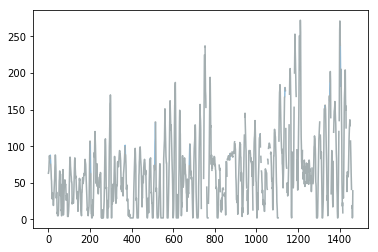

In [23]:
#test how the data is filled
test_df = fill_aq.sort_values(by='time').loc[fill_aq.station_id == 'dongsi_aq']
test_attr = 'O3'
plt.plot(test_df[test_attr+'_filled'].values,alpha=0.5)
plt.plot(test_df[test_attr].values,alpha=0.2)

In [24]:
def one_hot_stations(stations_df):
    stations_df['station_type_id'] = stations_df['station_type_id'].apply(int).apply(str)
    stations_df['station_id_int'] = stations_df['station_id_int'].apply(int).apply(str)
    stations = pd.get_dummies(stations_df[['station_id_int','station_type_id']],prefix=['station','stationType'])
    return pd.concat([stations_df,stations],axis=1),stations.columns

In [25]:
#remove PM10 outlier(this days all have extremely high value):
fill_aq = fill_aq.loc[(fill_aq.time < '2018-03-27 22:00:00')|(fill_aq.time > '2018-03-28 14:00:00')]

In [26]:
#prepare one hot info for stations
fill_aq,stations_col = one_hot_stations(fill_aq)

In [27]:
def add_rolling(df,attrs,freqs=['3h','6h','12h','1D','3D','7D']):
    df = df.sort_values(by='time')
    df.index = pd.to_datetime(df.time)
    new_attrs = []
    for attr in attrs:
        ##calculate the shift
        df[attr] = df[attr].fillna(method='ffill')
        df[attr+'shift1'] = df[attr].shift(1)
        df[attr+'_diff'] = df[attr] - df[attr+'shift1']
        df[attr+'_diff'] = df[attr+'_diff'].shift(1)
        new_attrs.append(attr+'_diff')
        for freq_str in freqs:
            rolling_df = df[attr].rolling(freq_str)
            df[attr+'_'+freq_str+'_mean'] = rolling_df.mean().shift(1)
            df[attr+'_'+freq_str+'_min'] = rolling_df.min().shift(1)
            df[attr+'_'+freq_str+'_max'] = rolling_df.max().shift(1)
            df[attr+'_'+freq_str+'_sum'] = rolling_df.sum().shift(1)
            df[attr+'_'+freq_str+'_std'] = rolling_df.var().shift(1)
        stat_attrs = [attr+'_'+freq_str+x for x in ['_mean','_min','_max','_sum','_std']]
        new_attrs += stat_attrs
    return df,new_attrs

In [28]:
def add_previous(df,attr,hours=5):
    '''
        add the raw values of 
    '''
    for i in range(1,hours+1):
        df[attr+"_shift"+str(i)] = df[attr].shift(i)
    new_attrs = [attr+"_shift"+str(i) for i in range(1,hours)]
    return df,new_attrs

In [29]:
def add_O3_features_single(group):
    #attrs for O3
    group.index = group['timestamp']
    new_attrs_all = []
    group,new_attrs_tmp = add_rolling(group,['O3_filled'],['3h','6h','12h','1D','3D','7D','10D'])
    new_attrs_all += new_attrs_tmp
    
    #same last few days values at the same hour
    group['O3_1d_shift'] = group['O3_filled'].shift(24)
    group['O3_2d_shift'] = group['O3_filled'].shift(48)
    #group['O3_season_shift'] = group['O3_filled'].shift(230)
    new_attrs_all += ['O3_1d_shift','O3_2d_shift']
    
    #weather_attrs
    weather_used = ['pressure','temperature','humidity','wind_speed']
    group,new_attrs_tmp = add_rolling(group,weather_used,['6h','12h','1D','5D'])
    new_attrs_all += new_attrs_tmp
    '''for w in weather_used:
        group,new_attrs_tmp = add_previous(group,w,3)
        new_attrs_all += new_attrs_tmp'''
        
    #add bad_weather sum
    group['bad_weather_6hsum'] = group['bad_weather'].rolling('6h').sum()
    new_attrs_all += ['bad_weather_6hsum']
    
    #add holidays features
    holiday_period = [[datetime.date(2018, 4, 5),datetime.date(2018, 4, 7)],\
                     [datetime.date(2018, 5, 1),datetime.date(2018, 5, 2)]]
    group['holiday'] = 0
    for holi_p in holiday_period:
        group[holi_p[0]:holi_p[1]]['holiday'] = 1
    group['holiday_sum'] = group['holiday'].rolling('1D').sum()
    new_attrs_all += ['holiday_sum','holiday']
    

    
    
    min_date = group.index.min()
    start_date = min_date+datetime.timedelta(days=7)
    group = group[start_date:]
    return group,new_attrs_all
    

In [30]:
def add_features_all(df,attr='PM10'):
    grouped = df.groupby('station_id')
    frames = []
    for name,df_group in grouped:
        print(name,df_group.time.unique()[-10:])
        if attr == 'PM10':
            group,new_features = add_pm10_features_single(df_group)
        elif attr == 'O3':
            print("Generating features for O3")
            group, new_features = add_O3_features_single(df_group)
        group = group.sort_index().reset_index(drop=True)
        frames.append(group)
    return pd.concat(frames,axis=0),new_features

In [31]:
fill_df,attrs_all_O3 = add_features_all(fill_aq,'O3')

aotizhongxin_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3


/home/xiaowen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


badaling_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3
beibuxinqu_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3
daxing_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3
dingling_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00

yufa_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3
yungang_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3
zhiwuyuan_aq ['2018-04-30 14:00:00' '2018-04-30 15:00:00' '2018-04-30 16:00:00'
 '2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00']
Generating features for O3


In [32]:
fill_df['weekday'] = fill_df['timestamp'].dt.weekday
fill_df = fill_df.loc[fill_df.station_id != 'zhiwuyuan_aq']

In [33]:
train_df = fill_df.loc[fill_df.time < '2018-04-29 00:00:00']
val_df = fill_df.loc[fill_df.time >= '2018-04-29 00:00:00']

In [34]:
train_df[attrs_all_O3] = train_df[attrs_all_O3].fillna(method='ffill')

/home/xiaowen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [35]:
date_cols = ['year','month','day','hour','weekday','date_h']
train_x = train_df[attrs_all_O3+list(stations_col)+date_cols+weather_used].values
train_y = train_df['O3_filled'].values

In [36]:
val_x = val_df[attrs_all_O3+list(stations_col)+date_cols+weather_used].values
val_y = val_df['O3_filled'].values

## model training

In [37]:
import lightgbm

train = lightgbm.Dataset(train_x,train_y)

In [38]:
    params = {  
        'boosting_type': 'gbdt',  
        'objective': 'mse',  
        'metric': {'mse'},  
        #'num_leaves':1000,  
        'max_depth': 8,  
        #'min_data_in_leaf': 450,  
        'learning_rate': 0.01,  
        'feature_fraction': 0.9,  
        'bagging_fraction': 0.95,  
        #'bagging_freq': 5,  
        #'lambda_l1': 1,    
        'lambda_l2': 0.001,  # 越小l2正则程度越高  
        #'min_gain_to_split': 0.2,  
        'verbose': 4,
    }  

In [39]:
models = lightgbm.train(params,train,num_boost_round = 600,valid_sets=[train],valid_names = ['train'])

[1]	train's l2: 2585.58
[2]	train's l2: 2553.33
[3]	train's l2: 2519.23
[4]	train's l2: 2486.23
[5]	train's l2: 2453.3
[6]	train's l2: 2420.96
[7]	train's l2: 2389.31
[8]	train's l2: 2358.25
[9]	train's l2: 2328.36
[10]	train's l2: 2298.46
[11]	train's l2: 2269.52
[12]	train's l2: 2241.01
[13]	train's l2: 2212.97
[14]	train's l2: 2184.29
[15]	train's l2: 2157.62
[16]	train's l2: 2130.64
[17]	train's l2: 2104.31
[18]	train's l2: 2078.64
[19]	train's l2: 2053.38
[20]	train's l2: 2028.43
[21]	train's l2: 2003.65
[22]	train's l2: 1979.85
[23]	train's l2: 1956.41
[24]	train's l2: 1933.15
[25]	train's l2: 1910.44
[26]	train's l2: 1887.91
[27]	train's l2: 1866.05
[28]	train's l2: 1844.22
[29]	train's l2: 1823.15
[30]	train's l2: 1801.87
[31]	train's l2: 1781.79
[32]	train's l2: 1760.57
[33]	train's l2: 1740.54
[34]	train's l2: 1721.06
[35]	train's l2: 1702.53
[36]	train's l2: 1683.71
[37]	train's l2: 1664.81
[38]	train's l2: 1646.63
[39]	train's l2: 1628.57
[40]	train's l2: 1610.01
[41]	train

[335]	train's l2: 381.266
[336]	train's l2: 380.523
[337]	train's l2: 379.759
[338]	train's l2: 379.014
[339]	train's l2: 378.315
[340]	train's l2: 377.608
[341]	train's l2: 376.819
[342]	train's l2: 376.012
[343]	train's l2: 375.358
[344]	train's l2: 374.62
[345]	train's l2: 373.986
[346]	train's l2: 373.194
[347]	train's l2: 372.482
[348]	train's l2: 371.754
[349]	train's l2: 371.168
[350]	train's l2: 370.58
[351]	train's l2: 369.821
[352]	train's l2: 369.09
[353]	train's l2: 368.38
[354]	train's l2: 367.707
[355]	train's l2: 367.075
[356]	train's l2: 366.434
[357]	train's l2: 365.87
[358]	train's l2: 365.339
[359]	train's l2: 364.678
[360]	train's l2: 364.059
[361]	train's l2: 363.353
[362]	train's l2: 362.805
[363]	train's l2: 362.258
[364]	train's l2: 361.623
[365]	train's l2: 360.963
[366]	train's l2: 360.317
[367]	train's l2: 359.612
[368]	train's l2: 359.054
[369]	train's l2: 358.418
[370]	train's l2: 357.818
[371]	train's l2: 357.127
[372]	train's l2: 356.566
[373]	train's l2:

[664]	train's l2: 258.994
[665]	train's l2: 258.822
[666]	train's l2: 258.65
[667]	train's l2: 258.426
[668]	train's l2: 258.202
[669]	train's l2: 258.057
[670]	train's l2: 257.831
[671]	train's l2: 257.627
[672]	train's l2: 257.397
[673]	train's l2: 257.211
[674]	train's l2: 257.004
[675]	train's l2: 256.799
[676]	train's l2: 256.587
[677]	train's l2: 256.409
[678]	train's l2: 256.217
[679]	train's l2: 256.002
[680]	train's l2: 255.794
[681]	train's l2: 255.613
[682]	train's l2: 255.428
[683]	train's l2: 255.229
[684]	train's l2: 255.074
[685]	train's l2: 254.876
[686]	train's l2: 254.754
[687]	train's l2: 254.588
[688]	train's l2: 254.381
[689]	train's l2: 254.201
[690]	train's l2: 254.028
[691]	train's l2: 253.838
[692]	train's l2: 253.67
[693]	train's l2: 253.511
[694]	train's l2: 253.364
[695]	train's l2: 253.206
[696]	train's l2: 253.021
[697]	train's l2: 252.867
[698]	train's l2: 252.734
[699]	train's l2: 252.564
[700]	train's l2: 252.366
[701]	train's l2: 252.218
[702]	train's 

In [40]:
import pickle
with open('/mnt/disks/bdt/5002/models/ffill_type3_O3_1201_2.pickle', 'wb') as f:
    pickle.dump(models, f)

In [41]:
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

In [42]:
pred = models.predict(val_x)
smape(pred,val_y)

0.44005907874286221

## Generate test row by row

In [41]:
## prepare test data

In [43]:
aq_test['weekday'] = aq_test['timestamp'].dt.weekday
aq_test = aq_test.loc[aq_test.station_id != 'zhiwuyuan_aq']
#prepare one hot info for stations
aq_test,stations_col = one_hot_stations(aq_test)

/home/xiaowen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
def rbr_predict(models,aq_test,train_df,val_df,attr_pred='PM10'):
    #prepare the pool for rolling
    df_pool = pd.concat([train_df,val_df],axis=0)
    df_pool = df_pool.loc[df_pool.time >= '2018-04-20 00:00:00']
    count = 0
    result_frames = []
    for time_s in aq_test.time.unique():
        curr_row = aq_test.loc[aq_test.time == time_s]
        pool_tmp = pd.concat([df_pool,curr_row],axis=0)
        features_df,attrs_all = add_features_all(pool_tmp,attr_pred)
        test_drop = features_df.drop_duplicates(subset=['station_id','time'])
        test_x = features_df[attrs_all+list(stations_col)+date_cols+weather_used].values
        features_df['pred'] = models.predict(test_x)

        features_df = features_df.loc[features_df.time == time_s]
        features_df[attr_pred+'_filled'] = features_df['pred']
        #print(df_pool.shape)
        df_pool = df_pool.append(features_df)
        #print(df_pool.shape)

        result_frames.append(features_df)
    return pd.concat(result_frames,axis=0)

In [45]:
result_df = rbr_predict(models,aq_test,train_df,val_df,'O3')

aotizhongxin_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00']
Generating features for O3
badaling_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00']
Generating features for O3


/home/xiaowen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


beibuxinqu_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00']
Generating features for O3
daxing_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00']
Generating features for O3
dingling_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00']
Generating features for O3
donggaocun_aq ['2018-04-30 15:00:00' '2018-04-30 16:00:00' '2018-04-30 17:00:00'
 '2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:

aotizhongxin_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00']
Generating features for O3
badaling_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00']
Generating features for O3
beibuxinqu_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00']
Generating features for O3
daxing_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 0

yufa_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00']
Generating features for O3
yungang_aq ['2018-04-30 16:00:00' '2018-04-30 17:00:00' '2018-04-30 18:00:00'
 '2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00']
Generating features for O3
aotizhongxin_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00']
Generating features for O3
badaling_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:

yongdingmennei_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00']
Generating features for O3
yongledian_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00']
Generating features for O3
yufa_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00']
Generating features for O3
yungang_aq ['2018-04-30 17:00:00' '2018-04-30 18:00:00' '2018-04-30 19:00:00'
 '2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01

yanqin_aq ['2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00']
Generating features for O3
yizhuang_aq ['2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00']
Generating features for O3
yongdingmennei_aq ['2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00']
Generating features for O3
yongledian_aq ['2018-04-30 18:00:00' '2018-04-30 19:00:00' '2018-04-30 20:00:00'
 '2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01

wanshouxigong_aq ['2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00']
Generating features for O3
xizhimenbei_aq ['2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00']
Generating features for O3
yanqin_aq ['2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00']
Generating features for O3
yizhuang_aq ['2018-04-30 19:00:00' '2018-04-30 20:00:00' '2018-04-30 21:00:00'
 '2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01

tongzhou_aq ['2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00']
Generating features for O3
wanliu_aq ['2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00']
Generating features for O3
wanshouxigong_aq ['2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00']
Generating features for O3
xizhimenbei_aq ['2018-04-30 20:00:00' '2018-04-30 21:00:00' '2018-04-30 22:00:00'
 '2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01

shunyi_aq ['2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00']
Generating features for O3
tiantan_aq ['2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00']
Generating features for O3
tongzhou_aq ['2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00']
Generating features for O3
wanliu_aq ['2018-04-30 21:00:00' '2018-04-30 22:00:00' '2018-04-30 23:00:00'
 '2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'


pinggu_aq ['2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00']
Generating features for O3
qianmen_aq ['2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00']
Generating features for O3
shunyi_aq ['2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00']
Generating features for O3
tiantan_aq ['2018-04-30 22:00:00' '2018-04-30 23:00:00' '2018-05-01 00:00:00'
 '2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 

nongzhanguan_aq ['2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00']
Generating features for O3
pingchang_aq ['2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00']
Generating features for O3
pinggu_aq ['2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00']
Generating features for O3
qianmen_aq ['2018-04-30 23:00:00' '2018-05-01 00:00:00' '2018-05-01 01:00:00'
 '2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:

miyunshuiku_aq ['2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00']
Generating features for O3
nongzhanguan_aq ['2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00']
Generating features for O3
pingchang_aq ['2018-05-01 00:00:00' '2018-05-01 01:00:00' '2018-05-01 02:00:00'
 '2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-0

mentougou_aq ['2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00']
Generating features for O3
miyun_aq ['2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00']
Generating features for O3
miyunshuiku_aq ['2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-01 01:00:00' '2018-05-01 02:00:00' '2018-05-01 03:00:00'
 '2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09

huairou_aq ['2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00']
Generating features for O3
liulihe_aq ['2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00']
Generating features for O3
mentougou_aq ['2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00']
Generating features for O3
miyun_aq ['2018-05-01 02:00:00' '2018-05-01 03:00:00' '2018-05-01 04:00:00'
 '2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'

guanyuan_aq ['2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00']
Generating features for O3
gucheng_aq ['2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00']
Generating features for O3
huairou_aq ['2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00']
Generating features for O3
liulihe_aq ['2018-05-01 03:00:00' '2018-05-01 04:00:00' '2018-05-01 05:00:00'
 '2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00

fangshan_aq ['2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00']
Generating features for O3
guanyuan_aq ['2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00']
Generating features for O3
gucheng_aq ['2018-05-01 04:00:00' '2018-05-01 05:00:00' '2018-05-01 06:00:00'
 '2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 

dongsi_aq ['2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00']
Generating features for O3
fangshan_aq ['2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-01 05:00:00' '2018-05-01 06:00:00' '2018-05-01 07:00:00'
 '2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01

dingling_aq ['2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00']
Generating features for O3
donggaocun_aq ['2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00']
Generating features for O3
dongsi_aq ['2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-01 06:00:00' '2018-05-01 07:00:00' '2018-05-01 08:00:00'
 '2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:

beibuxinqu_aq ['2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00']
Generating features for O3
daxing_aq ['2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00']
Generating features for O3
dingling_aq ['2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00']
Generating features for O3
donggaocun_aq ['2018-05-01 07:00:00' '2018-05-01 08:00:00' '2018-05-01 09:00:00'
 '2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:

aotizhongxin_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00']
Generating features for O3
badaling_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00']
Generating features for O3
beibuxinqu_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00']
Generating features for O3
daxing_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 1

yufa_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00']
Generating features for O3
yungang_aq ['2018-05-01 08:00:00' '2018-05-01 09:00:00' '2018-05-01 10:00:00'
 '2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00']
Generating features for O3
aotizhongxin_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00']
Generating features for O3
badaling_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:

yongdingmennei_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00']
Generating features for O3
yongledian_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00']
Generating features for O3
yufa_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00']
Generating features for O3
yungang_aq ['2018-05-01 09:00:00' '2018-05-01 10:00:00' '2018-05-01 11:00:00'
 '2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17

yanqin_aq ['2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00']
Generating features for O3
yizhuang_aq ['2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00']
Generating features for O3
yongdingmennei_aq ['2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00']
Generating features for O3
yongledian_aq ['2018-05-01 10:00:00' '2018-05-01 11:00:00' '2018-05-01 12:00:00'
 '2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01

wanshouxigong_aq ['2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00']
Generating features for O3
xizhimenbei_aq ['2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00']
Generating features for O3
yanqin_aq ['2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00']
Generating features for O3
yizhuang_aq ['2018-05-01 11:00:00' '2018-05-01 12:00:00' '2018-05-01 13:00:00'
 '2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01

tongzhou_aq ['2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00']
Generating features for O3
wanliu_aq ['2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00']
Generating features for O3
wanshouxigong_aq ['2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00']
Generating features for O3
xizhimenbei_aq ['2018-05-01 12:00:00' '2018-05-01 13:00:00' '2018-05-01 14:00:00'
 '2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01

shunyi_aq ['2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00']
Generating features for O3
tiantan_aq ['2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00']
Generating features for O3
tongzhou_aq ['2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00']
Generating features for O3
wanliu_aq ['2018-05-01 13:00:00' '2018-05-01 14:00:00' '2018-05-01 15:00:00'
 '2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'


pinggu_aq ['2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00']
Generating features for O3
qianmen_aq ['2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00']
Generating features for O3
shunyi_aq ['2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00']
Generating features for O3
tiantan_aq ['2018-05-01 14:00:00' '2018-05-01 15:00:00' '2018-05-01 16:00:00'
 '2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 

nongzhanguan_aq ['2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00']
Generating features for O3
pingchang_aq ['2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00']
Generating features for O3
pinggu_aq ['2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00']
Generating features for O3
qianmen_aq ['2018-05-01 15:00:00' '2018-05-01 16:00:00' '2018-05-01 17:00:00'
 '2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:

miyunshuiku_aq ['2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00']
Generating features for O3
nongzhanguan_aq ['2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00']
Generating features for O3
pingchang_aq ['2018-05-01 16:00:00' '2018-05-01 17:00:00' '2018-05-01 18:00:00'
 '2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-0

mentougou_aq ['2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00']
Generating features for O3
miyun_aq ['2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00']
Generating features for O3
miyunshuiku_aq ['2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-01 17:00:00' '2018-05-01 18:00:00' '2018-05-01 19:00:00'
 '2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01

huairou_aq ['2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00']
Generating features for O3
liulihe_aq ['2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00']
Generating features for O3
mentougou_aq ['2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00']
Generating features for O3
miyun_aq ['2018-05-01 18:00:00' '2018-05-01 19:00:00' '2018-05-01 20:00:00'
 '2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'

guanyuan_aq ['2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00']
Generating features for O3
gucheng_aq ['2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00']
Generating features for O3
huairou_aq ['2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00']
Generating features for O3
liulihe_aq ['2018-05-01 19:00:00' '2018-05-01 20:00:00' '2018-05-01 21:00:00'
 '2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00

fangshan_aq ['2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00']
Generating features for O3
guanyuan_aq ['2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00']
Generating features for O3
gucheng_aq ['2018-05-01 20:00:00' '2018-05-01 21:00:00' '2018-05-01 22:00:00'
 '2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 

dongsi_aq ['2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00']
Generating features for O3
fangshan_aq ['2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-01 21:00:00' '2018-05-01 22:00:00' '2018-05-01 23:00:00'
 '2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02

dingling_aq ['2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00']
Generating features for O3
donggaocun_aq ['2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00']
Generating features for O3
dongsi_aq ['2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-01 22:00:00' '2018-05-01 23:00:00' '2018-05-02 00:00:00'
 '2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:

beibuxinqu_aq ['2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00']
Generating features for O3
daxing_aq ['2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00']
Generating features for O3
dingling_aq ['2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00']
Generating features for O3
donggaocun_aq ['2018-05-01 23:00:00' '2018-05-02 00:00:00' '2018-05-02 01:00:00'
 '2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:

aotizhongxin_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00']
Generating features for O3
badaling_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00']
Generating features for O3
beibuxinqu_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00']
Generating features for O3
daxing_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 0

yufa_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00']
Generating features for O3
yungang_aq ['2018-05-02 00:00:00' '2018-05-02 01:00:00' '2018-05-02 02:00:00'
 '2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00']
Generating features for O3
aotizhongxin_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00']
Generating features for O3
badaling_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:

yongdingmennei_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00']
Generating features for O3
yongledian_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00']
Generating features for O3
yufa_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00']
Generating features for O3
yungang_aq ['2018-05-02 01:00:00' '2018-05-02 02:00:00' '2018-05-02 03:00:00'
 '2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09

yanqin_aq ['2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00']
Generating features for O3
yizhuang_aq ['2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00']
Generating features for O3
yongdingmennei_aq ['2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00']
Generating features for O3
yongledian_aq ['2018-05-02 02:00:00' '2018-05-02 03:00:00' '2018-05-02 04:00:00'
 '2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02

wanshouxigong_aq ['2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00']
Generating features for O3
xizhimenbei_aq ['2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00']
Generating features for O3
yanqin_aq ['2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00']
Generating features for O3
yizhuang_aq ['2018-05-02 03:00:00' '2018-05-02 04:00:00' '2018-05-02 05:00:00'
 '2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02

tongzhou_aq ['2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00']
Generating features for O3
wanliu_aq ['2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00']
Generating features for O3
wanshouxigong_aq ['2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00']
Generating features for O3
xizhimenbei_aq ['2018-05-02 04:00:00' '2018-05-02 05:00:00' '2018-05-02 06:00:00'
 '2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02

shunyi_aq ['2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00']
Generating features for O3
tiantan_aq ['2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00']
Generating features for O3
tongzhou_aq ['2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00']
Generating features for O3
wanliu_aq ['2018-05-02 05:00:00' '2018-05-02 06:00:00' '2018-05-02 07:00:00'
 '2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'


pinggu_aq ['2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00']
Generating features for O3
qianmen_aq ['2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00']
Generating features for O3
shunyi_aq ['2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00']
Generating features for O3
tiantan_aq ['2018-05-02 06:00:00' '2018-05-02 07:00:00' '2018-05-02 08:00:00'
 '2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 

nongzhanguan_aq ['2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00']
Generating features for O3
pingchang_aq ['2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00']
Generating features for O3
pinggu_aq ['2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00']
Generating features for O3
qianmen_aq ['2018-05-02 07:00:00' '2018-05-02 08:00:00' '2018-05-02 09:00:00'
 '2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:

miyunshuiku_aq ['2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00']
Generating features for O3
nongzhanguan_aq ['2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00']
Generating features for O3
pingchang_aq ['2018-05-02 08:00:00' '2018-05-02 09:00:00' '2018-05-02 10:00:00'
 '2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-0

mentougou_aq ['2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00']
Generating features for O3
miyun_aq ['2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00']
Generating features for O3
miyunshuiku_aq ['2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00']
Generating features for O3
nansanhuan_aq ['2018-05-02 09:00:00' '2018-05-02 10:00:00' '2018-05-02 11:00:00'
 '2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17

huairou_aq ['2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00']
Generating features for O3
liulihe_aq ['2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00']
Generating features for O3
mentougou_aq ['2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00']
Generating features for O3
miyun_aq ['2018-05-02 10:00:00' '2018-05-02 11:00:00' '2018-05-02 12:00:00'
 '2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'

guanyuan_aq ['2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00']
Generating features for O3
gucheng_aq ['2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00']
Generating features for O3
huairou_aq ['2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00']
Generating features for O3
liulihe_aq ['2018-05-02 11:00:00' '2018-05-02 12:00:00' '2018-05-02 13:00:00'
 '2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00

fangshan_aq ['2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00' '2018-05-02 19:00:00' '2018-05-02 20:00:00'
 '2018-05-02 21:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00' '2018-05-02 19:00:00' '2018-05-02 20:00:00'
 '2018-05-02 21:00:00']
Generating features for O3
guanyuan_aq ['2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00' '2018-05-02 19:00:00' '2018-05-02 20:00:00'
 '2018-05-02 21:00:00']
Generating features for O3
gucheng_aq ['2018-05-02 12:00:00' '2018-05-02 13:00:00' '2018-05-02 14:00:00'
 '2018-05-02 15:00:00' '2018-05-02 16:00:00' '2018-05-02 17:00:00'
 '2018-05-02 18:00:00' '2018-05-02 19:00:00' '2018-05-02 

dongsi_aq ['2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00' '2018-05-02 20:00:00' '2018-05-02 21:00:00'
 '2018-05-02 22:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00' '2018-05-02 20:00:00' '2018-05-02 21:00:00'
 '2018-05-02 22:00:00']
Generating features for O3
fangshan_aq ['2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00' '2018-05-02 20:00:00' '2018-05-02 21:00:00'
 '2018-05-02 22:00:00']
Generating features for O3
fengtaihuayuan_aq ['2018-05-02 13:00:00' '2018-05-02 14:00:00' '2018-05-02 15:00:00'
 '2018-05-02 16:00:00' '2018-05-02 17:00:00' '2018-05-02 18:00:00'
 '2018-05-02 19:00:00' '2018-05-02 20:00:00' '2018-05-02

dingling_aq ['2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00' '2018-05-02 21:00:00' '2018-05-02 22:00:00'
 '2018-05-02 23:00:00']
Generating features for O3
donggaocun_aq ['2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00' '2018-05-02 21:00:00' '2018-05-02 22:00:00'
 '2018-05-02 23:00:00']
Generating features for O3
dongsi_aq ['2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00' '2018-05-02 21:00:00' '2018-05-02 22:00:00'
 '2018-05-02 23:00:00']
Generating features for O3
dongsihuan_aq ['2018-05-02 14:00:00' '2018-05-02 15:00:00' '2018-05-02 16:00:00'
 '2018-05-02 17:00:00' '2018-05-02 18:00:00' '2018-05-02 19:00:00'
 '2018-05-02 20:00:00' '2018-05-02 21:00:00' '2018-05-02 22:

In [46]:
result_df.to_csv('/mnt/disks/bdt/5002/result/O3_prediction_1201_2.csv')

In [47]:
eval_df = result_df.dropna(subset=['O3'])
eval_df = eval_df.loc[eval_df.station_id != 'zhiwuyuan_aq']

In [48]:
import evaluation
evaluation.smape(eval_df['O3'],eval_df['pred'])

0.49824450403711185

In [49]:
stat_df = eval_df.loc[eval_df.station_id == 'dongsi_aq']

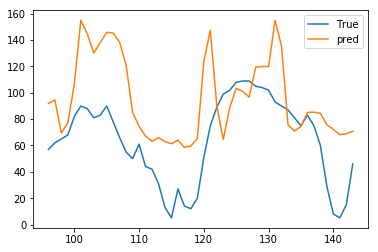

In [50]:
plt.plot(stat_df['O3'],label='True')
plt.plot(stat_df['pred'],label='pred')
plt.legend()

In [ ]:
stat_df[['station_id','pred','PM10','PM10_2d_shift','time']].head()